In [131]:
import getpass
import imaplib
import email
import email.mime
import quopri
import pandas as pd
import base64

вводим данные

In [132]:
URL = 'imap.gmail.com'
LOGIN = 'zibumzibumich@gmail.com'
PASSWORD = getpass.getpass()

логинимся

In [133]:
mail = imaplib.IMAP4_SSL(URL)
mail.login(LOGIN, PASSWORD)

('OK', [b'zibumzibumich@gmail.com authenticated (Success)'])

In [203]:
mail.list()

('OK',
 [b'(\\HasNoChildren) "/" "Deleted Messages"',
  b'(\\HasNoChildren) "/" "INBOX"',
  b'(\\HasNoChildren) "/" "Sent Messages"',
  b'(\\HasChildren \\Noselect) "/" "[Gmail]"',
  b'(\\HasNoChildren \\Important) "/" "[Gmail]/&BBIEMAQ2BD0EPgQ1-"',
  b'(\\All \\HasNoChildren) "/" "[Gmail]/&BBIEQQRP- &BD8EPgRHBEIEMA-"',
  b'(\\HasNoChildren \\Trash) "/" "[Gmail]/&BBoEPgRABDcEOAQ9BDA-"',
  b'(\\HasNoChildren \\Sent) "/" "[Gmail]/&BB4EQgQ,BEAEMAQyBDsENQQ9BD0ESwQ1-"',
  b'(\\Flagged \\HasNoChildren) "/" "[Gmail]/&BB8EPgQ8BDUERwQ1BD0EPQRLBDU-"',
  b'(\\HasNoChildren \\Junk) "/" "[Gmail]/&BCEEPwQwBDw-"',
  b'(\\Drafts \\HasNoChildren) "/" "[Gmail]/&BCcENQRABD0EPgQyBDgEOgQ4-"',
  b'(\\HasNoChildren) "/" "&BB8EQAQ+BEcEOARCBDAEPQQ9BD4ENQ-"'])

выбираем ящик

In [204]:
mail.select("INBOX")

('OK', [b'3049'])

возьмем первые 150 писем

In [236]:
ok, numbers = mail.search(None, "ALL")
assert ok == 'OK'
uids = numbers[0].split()
uids = [id.decode("utf-8") for id in uids ]
uids = uids[-1:-100:-1] # письма идут в обратном порядке, возьму 100 самых новых
ok, messages = mail.fetch(','.join(uids), '(BODY[HEADER.FIELDS (SUBJECT FROM DATE)])')
assert ok == 'OK'

создадим датасем
`[date, from, subject]`

In [237]:
date_list = []
from_list = [] 
subject_text = []
for i, message in messages[::2]:
    msg = email.message_from_bytes(message)
    fromlist = msg.get('From')
    if fromlist.startswith('=?utf-8?q?') or \
        fromlist.startswith('=?UTF-8?Q?') or \
        fromlist.startswith('=?UTF-8?q?'):
        continue
    if fromlist.startswith('=?UTF-8?B?'):
        start = fromlist.find( '=?UTF-8?B?' )
        end = fromlist.rfind( '?=' )
        b64encoded = fromlist[start+len('=?UTF-8?B?'):end]
        b64decoded = base64.b64decode(b64encoded)
        b64decoded = b64decoded.decode('utf-8')
        fromlist = fromlist[:start] + b64decoded + fromlist[end+len('?='):]
    if fromlist.startswith('=?utf-8?b?'):
        start = fromlist.find( '=?utf-8?b?' )
        end = fromlist.rfind( '?=' )
        b64encoded = fromlist[start+len('=?utf-8?b?'):end]
        b64decoded = base64.b64decode(b64encoded)
        b64decoded = b64decoded.decode('utf-8')
        fromlist = fromlist[:start] + b64decoded + fromlist[end+len('?='):]
    if fromlist.startswith('=?UTF-8?b?'):
        start = fromlist.find( '=?UTF-8?b?' )
        end = fromlist.rfind( '?=' )
        b64encoded = fromlist[start+len('=?UTF-8?b?'):end]
        b64decoded = base64.b64decode(b64encoded)
        b64decoded = b64decoded.decode('utf-8')
        fromlist = fromlist[:start] + b64decoded + fromlist[end+len('?='):]
    
    decode = email.header.decode_header(msg['Subject'])[0]
    if isinstance(decode[0],bytes):
        try:
            decoded = decode[0].decode()
            subject_text.append(decoded)
        except UnicodeDecodeError:
            continue
    else:
        subject_text.append(decode[0])
    from_list.append(fromlist)
    date_list.append(msg.get('date'))

date_list = pd.to_datetime(date_list)
date_list1 = []
for i, item in enumerate(date_list):
    try:
        date_list1.append(item.isoformat(' ')[:-6])
    except AttributeError:
        del subject_text[i]
        del from_list[i]
print(len(subject_text))
print(len(from_list))
print(len(date_list1))
df = pd.DataFrame(data={'Date':date_list1, 'Sender':from_list, 'Subject':subject_text})
print(df.head())
df.to_csv('inbox_email.csv',index=False)

92
92
92
                  Date                                             Sender  \
0  2023-02-27 14:15:21         "Alfa Digital" <no-reply@r2d2.alfabank.ru>   
1  2023-02-27 14:46:18                                        asav@hse.ru   
2  2023-02-27 08:54:21  Лиза Петяева (Google Документы)\r\n <comments-...   
3  2023-02-27 19:03:10        Олимпиадные школы МФТИ\r\n <osh@it-edu.com>   
4  2023-02-28 09:31:09                   Зарплата.ру <info@i.zarplata.ru>   

                                             Subject  
0    🅰️ Поступайте в магистратуру Альфа-Банка в МФТИ  
1  Олимпиада «Высшая лига»: равные возможности дл...  
2                         Bordyugov_Project_Proposal  
3  Второй Всероссийский конкурс Open Source проек...  
4                         , 4 причины создать резюме  


посмотрим на структуру данных

In [238]:
data = pd.read_csv('inbox_email.csv')
data.head()

Date                                             Sender  \
0  2023-02-27 14:15:21         "Alfa Digital" <no-reply@r2d2.alfabank.ru>   
1  2023-02-27 14:46:18                                        asav@hse.ru   
2  2023-02-27 08:54:21  Лиза Петяева (Google Документы)\r\n <comments-...   
3  2023-02-27 19:03:10        Олимпиадные школы МФТИ\r\n <osh@it-edu.com>   
4  2023-02-28 09:31:09                   Зарплата.ру <info@i.zarplata.ru>   

                                             Subject  
0    🅰️ Поступайте в магистратуру Альфа-Банка в МФТИ  
1  Олимпиада «Высшая лига»: равные возможности дл...  
2                         Bordyugov_Project_Proposal  
3  Второй Всероссийский конкурс Open Source проек...  
4                         , 4 причины создать резюме

посмотрим на статистические данные

In [239]:
data.describe()

Date                      Sender  \
count                    92                          92   
unique                   92                          28   
top     2023-02-27 14:15:21  Boosty <noreply@boosty.to>   
freq                      1                          21   

                                Subject  
count                                92  
unique                               54  
top     Оповещение системы безопасности  
freq                                 14

добавим данные, которые поможгут в оценке времени отпраления сообщения

In [240]:
from datetime import datetime
FMT = '%H:%M:%S'
data['Time'] = data['Date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime(FMT)
)
data['SinceMid'] = data['Time'].apply(
    lambda x: (datetime.strptime(x, FMT) - datetime.strptime("00:00:00", FMT)).seconds
) / 60 / 60

In [241]:
data.head()

Date                                             Sender  \
0  2023-02-27 14:15:21         "Alfa Digital" <no-reply@r2d2.alfabank.ru>   
1  2023-02-27 14:46:18                                        asav@hse.ru   
2  2023-02-27 08:54:21  Лиза Петяева (Google Документы)\r\n <comments-...   
3  2023-02-27 19:03:10        Олимпиадные школы МФТИ\r\n <osh@it-edu.com>   
4  2023-02-28 09:31:09                   Зарплата.ру <info@i.zarplata.ru>   

                                             Subject      Time   SinceMid  
0    🅰️ Поступайте в магистратуру Альфа-Банка в МФТИ  14:15:21  14.255833  
1  Олимпиада «Высшая лига»: равные возможности дл...  14:46:18  14.771667  
2                         Bordyugov_Project_Proposal  08:54:21   8.905833  
3  Второй Всероссийский конкурс Open Source проек...  19:03:10  19.052778  
4                         , 4 причины создать резюме  09:31:09   9.519167

In [242]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

построим облако слов, с самыми частыми словами в темах писем

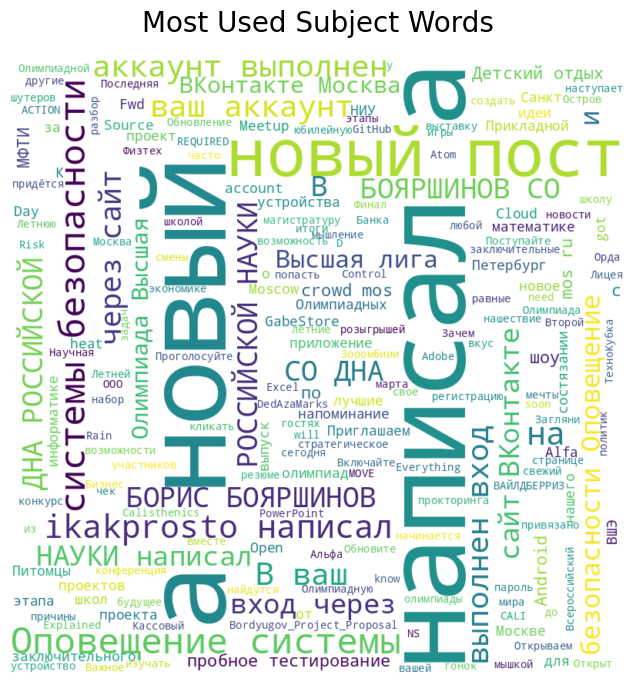

In [243]:
text = ""
for item in data["Subject"]:
    if isinstance(item,str):
        text += " " + item
    text.replace("'", "")
    text.replace(",","")
    text.replace('"','')


# Create the wordcloud object
wordcloud = WordCloud(width=800, height=800, background_color="white")

# Display the generated image:
wordcloud.generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Most Used Subject Words", fontsize=20,ha="center", pad=20)
plt.show()

когда меня чаще всего заваливают спамом?

/var/folders/s6/4vs_0y5d6_3fnghd_d3hfb080000gp/T/ipykernel_12605/271151331.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["SinceMid"],bins=20)


Text(0.5, 1.0, 'Hours since midnight')

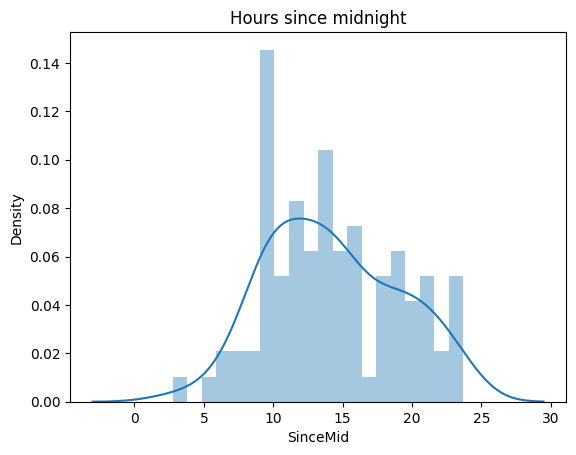

In [244]:
import seaborn as sns
sns.distplot(data["SinceMid"],bins=20)
plt.title("Hours since midnight")

In [245]:
data['Sender'].value_counts()

Boosty <noreply@boosty.to>                                                               21
VK <admin@notify.vk.com>                                                                 13
Google <no-reply@accounts.google.com>                                                    13
"Город идей". Платформа П\r\n <crowd@mos.ru>                                              6
Олимпиадные школы МФТИ\r\n <osh@it-edu.com>                                               5
asav@hse.ru                                                                               5
"Alfa Digital" <no-reply@r2d2.alfabank.ru>                                                3
Магазин GabeStore <marketing@gabestore.ru>                                                3
yulia.rumyantseva@gmail.com                                                               2
info@wildberries.ru                                                                       2
SoundCloud <no-reply@announcements.soundcloud.com>                              

самые активные спамщики?

<Axes: >

) missing from current font.ython/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.ython/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


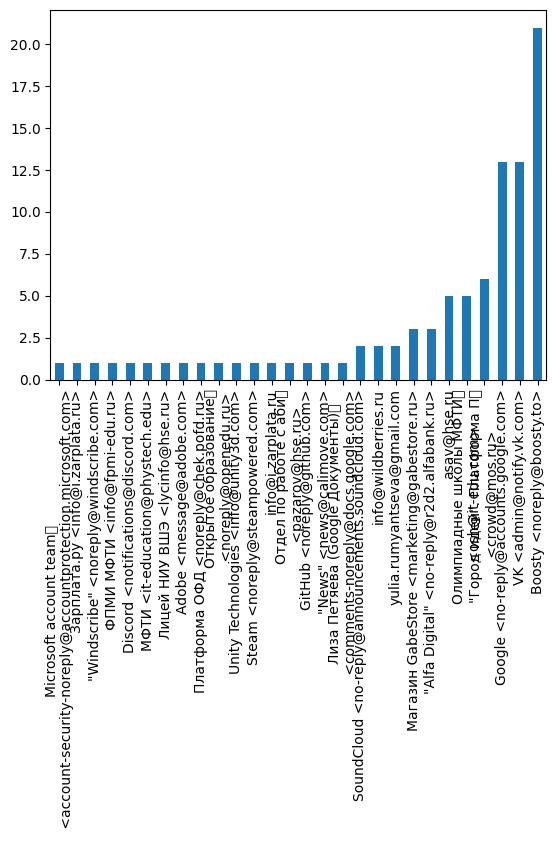

In [247]:
data['Sender'].value_counts().sort_values().plot(kind='bar')